# Use Case: Context-Aware Anomaly Detection im zivilen Luftraum

### 1. Die physikalische Ausgangslage
In der Luftfahrt unterliegen alle Bewegungen strengen physikalischen Gesetzen. Obwohl jedes Luftfahrzeug ein individuelles Profil hat, ergibt sich in der Masse ein stabiles Muster.

Es gelten fundamentale Regeln der Aerodynamik:
* **Höhe & Geschwindigkeit:** In dünnerer Luft (hohe Flughöhe) müssen Flugzeuge schneller fliegen, um genügend Auftrieb zu erzeugen.

* **Start & Landung:** Nahe am Boden sind Flugzeuge zwangsläufig langsamer.

**Realistische Benchmarks für "Normalität":**
* **Reiseflughöhe:** Zivile Jets operieren meist zwischen **9.000m und 12.000m**.
* **Reisegeschwindigkeit:** Üblich sind **800 bis 950 km/h**.
* **Stall Speed:** Die meisten Verkehrsflugzeuge benötigen mind. **200-300 km/h**, um stabil zu fliegen.

---

### 2. Das Ziel: Anomalie-Erkennung
Wir nutzen den **Isolation Forest**-Algorithmus (Unsupervised Learning), um Datenpunkte zu finden, die massiv von dieser "Norm" abweichen. Dabei suchen wir zwei Arten von Ausreißern:

1.  **Technische Anomalien:** Sensorfehler, bei denen unrealistische Werte übertragen werden (z. B. 10 km/h in 10.000m Höhe).
2.  **Operative Anomalien:** Luftfahrzeuge, die sich am physikalischen Limit bewegen (z. B. Kampfjets im Tiefflug oder extrem langsame Objekte).

---

### 3. Data Enrichment & Context-Awareness
Eine rein statistische Analyse hat eine Schwäche: Sie kennt den Unterschied zwischen einem **Airbus A320** und einem **Hubschrauber** nicht. Ein Hubschrauber, der mit 0 km/h schwebt, würde von einem "dummen" Algorithmus als Absturz (Anomalie) markiert werden.

Um dies zu beheben, integrieren wir eine **zweite Datenquelle**.

**Die Datenbasis (Data Engineering):**
Wir nutzen die **OpenSky Aircraft Database**, die wir zuvor über unsere Pipeline (`aircraft_type_ingest_s3.py`) automatisiert ingestiert und als performante **Parquet-Datei** (`aircraft_database.parquet`) bereitgestellt haben.

**Der Kontext-Join:**
Über die eindeutige Transponder-ID (**`icao24`**) verknüpfen wir die Positionsdaten mit den Stammdaten:
* `manufacturerName` (z.B. Airbus, Robinson)
* `model` (z.B. A320, R44)
* `categoryDescription` (z.B. Rotorcraft, Glider)

**Die Forschungsfrage:**
*Ist der gefundene Ausreißer ein physikalischer Fehler (z.B. ein Jet, der zu langsam ist) oder einfach ein Hubschrauber, der sich für seinen Typ völlig normal verhält?*

--- 1. LADEN & VISUALISIERUNG ---
📂 Lade Datensatz: run_1769032455
✅ Daten geladen: 567,496 Punkte.
🎨 Erstelle Diagramm mit atmosphärischen Schichten...


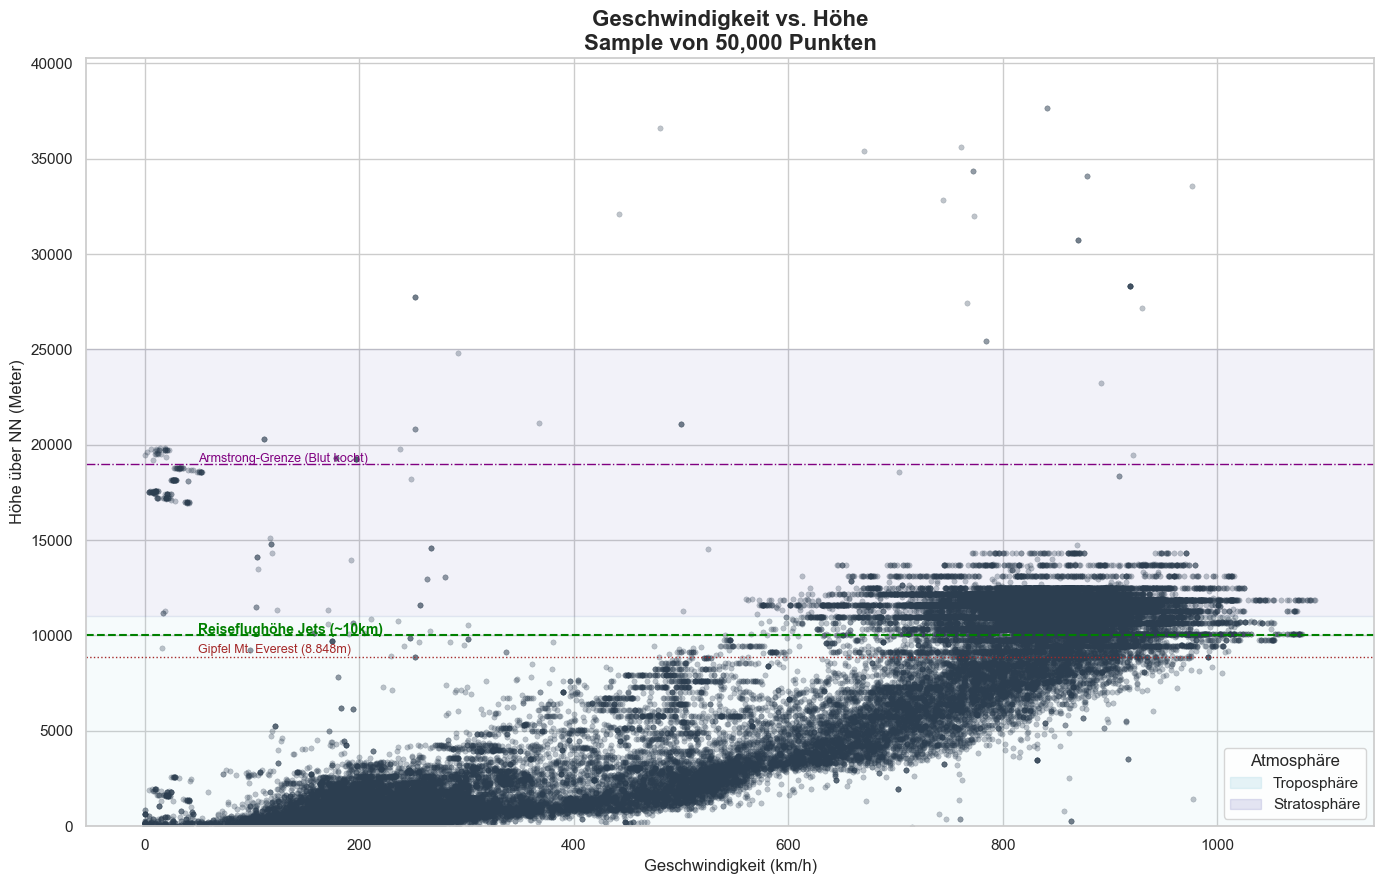

In [25]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Design-Einstellungen
sns.set_theme(style="whitegrid")

print("--- 1. LADEN & VISUALISIERUNG ---")

# 1. DATEN LADEN
base_path = "../data/processed/run_*"
if not glob.glob(base_path): base_path = "../../data/processed/run_*"
latest_run = max(glob.glob(base_path), key=os.path.getctime)
print(f"📂 Lade Datensatz: {os.path.basename(latest_run)}")

df = pd.read_parquet(latest_run)

# 2. DATEN VORBEREITEN
cols_to_fix = ['baroaltitude', 'velocity']
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df[df['onground'] == 'False'].dropna(subset=cols_to_fix).copy()
df_clean['velocity_kmh'] = df_clean['velocity'] * 3.6

print(f"✅ Daten geladen: {len(df_clean):,} Punkte.")

# 3. VISUALISIERUNG MIT KONTEXT
print("🎨 Erstelle Diagramm mit atmosphärischen Schichten...")
plt.figure(figsize=(14, 9)) # Etwas höher für die Schichten

# Sample
sample_size = min(50000, len(df_clean))
df_plot = df_clean.sample(n=sample_size, random_state=42)

# A) HINTERGRUND-SCHICHTEN (Atmosphäre)
# Troposphäre (Wettergeschehen, bis ca 11-12km)
plt.axhspan(0, 11000, color='lightblue', alpha=0.1, label='Troposphäre (Wetter)')
# Stratosphäre (Ruhig, darüber)
plt.axhspan(11000, 25000, color='darkblue', alpha=0.05, label='Stratosphäre')

# B) DER PLOT
sns.scatterplot(
    data=df_plot, 
    x='velocity_kmh', y='baroaltitude',
    color='#2c3e50', alpha=0.3, s=15, edgecolor=None
)

# C) WICHTIGE LINIEN & TEXTE
# 1. Mount Everest (8.848m) - Das höchste Hindernis
plt.axhline(y=8848, color='brown', linestyle=':', linewidth=1)
plt.text(50, 8900, 'Gipfel Mt. Everest (8.848m)', color='brown', fontsize=9, va='bottom')

# 2. Typische Reiseflughöhe (ca. 10.000m - 12.000m)
plt.axhline(y=10000, color='green', linestyle='--', linewidth=1.5)
plt.text(50, 10100, 'Reiseflughöhe Jets (~10km)', color='green', fontsize=10, fontweight='bold')

# 3. Armstrong-Grenze (ca. 19.000m - Blut kocht, fast Weltraum)
# Nur anzeigen, wenn wir Daten in der Nähe haben, sonst wird der Plot zu leer
if df_clean['baroaltitude'].max() > 15000:
    plt.axhline(y=19000, color='purple', linestyle='-.', linewidth=1)
    plt.text(50, 19100, 'Armstrong-Grenze (Blut kocht)', color='purple', fontsize=9)

# Labels & Titel
plt.title(f"Geschwindigkeit vs. Höhe\nSample von {sample_size:,} Punkten", fontsize=16, fontweight='bold')
plt.xlabel("Geschwindigkeit (km/h)")
plt.ylabel("Höhe über NN (Meter)")
plt.ylim(0, max(14000, df_clean['baroaltitude'].max() * 1.05)) # Y-Achse dynamisch, aber mind. bis 14km

# Legende für die Schichten (Trick mit Fake-Elementen)
tropo_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Troposphäre')
strato_patch = mpatches.Patch(color='darkblue', alpha=0.1, label='Stratosphäre')
plt.legend(handles=[tropo_patch, strato_patch], loc='lower right', title="Atmosphäre")

plt.tight_layout()
plt.show()

### Interpretation der Grafik: Geschwindigkeit vs. Höhe

Das Diagramm visualisiert eindrucksvoll die physikalischen Gesetzmäßigkeiten der Luftfahrt, offenbart aber bei genauerem Hinsehen massive Anomalien, die wir im nächsten Schritt untersuchen müssen.

#### 1. Die "Main Cloud" (Physikalische Normalität)
Der Großteil der 50.000 Datenpunkte bildet eine dichte, gekrümmte Wolke.
* **Der Aufstieg:** Man erkennt klar den korrelierten Anstieg – je höher das Flugzeug steigt, desto schneller muss es fliegen.
* **Die Cruise-Phase:** Die höchste Dichte (dunkelblaue Masse) liegt exakt auf der grünen Linie (**10.000m - 12.000m**) bei einer Geschwindigkeit von **800 - 950 km/h**. Das ist der operative Standard für Verkehrsflugzeuge (Airbus A320, Boeing 737 etc.). In dieser Höhe ist die Luft dünn genug für effizientes Reisen, aber dick genug für den Auftrieb.

#### 2. Die Anomalien (Unsere Zielgruppe)
Abseits dieser Norm sehen wir extreme Ausreißer, die physikalisch kaum erklärbar scheinen:

**A) Die "Geister" der Stratosphäre (High Altitude, Zero Speed)**
* **Beobachtung:** Eine isolierte Punktwolke oben links bei **17.000m bis 20.000m** Höhe (nahe der Armstrong-Grenze), aber mit **nahezu 0 km/h**.
* **Physikalische Einordnung:** Ein Flugzeug würde hier sofort abstürzen (Stall). In dieser Höhe ist die Luft so dünn, dass man extrem schnell sein müsste, um Auftrieb zu erzeugen.
* **Hypothese:** Hier handelt es sich höchstwahrscheinlich **nicht um Flugzeuge**, sondern um Wetterballons, Forschungsballons oder stationäre Höhenplattformen (HAPS), die sich mit dem Wind treiben lassen. Alternativ: Fehlerhafte GPS-Höhendaten von Bodenstationen.

**B) Die Tiefflug-Raser (Low Altitude, High Speed)**
* **Beobachtung:** Datenpunkte bei nur **2.000m - 4.000m** Höhe, aber mit **> 800 km/h**.
* **Physikalische Einordnung:** In dieser dichten Luftschicht ist der Luftwiderstand enorm. Ein ziviles Flugzeug dürfte hier aus Lärmschutz- und Strukturgründen oft nicht schneller als 450 km/h (250 knots) fliegen.
* **Hypothese:** Dies könnten militärische Übungsflüge (Kampfjets) sein oder massive Sensorfehler.

**C) Die Weltraum-Kandidaten (Extreme Altitude)**
* **Beobachtung:** Vereinzelte Punkte bei **30.000m bis 35.000m**.
* **Physikalische Einordnung:** Die Dienstgipfelhöhe fast aller zivilen Jets endet bei 13.000m. Selbst die Concorde flog nur auf ca. 18.000m.
* **Hypothese:** Entweder handelt es sich um Suborbital-Flüge/Raketenstarts, Spionageballons oder – am wahrscheinlichsten – um **Datenmüll (Glitches)**, den wir filtern müssen.

---
**Das Problem:**
Ein rein statistischer Algorithmus würde die "Geister der Stratosphäre" (A) als massive Anomalie markieren, da sie weit weg vom Durchschnitt liegen. Wenn es sich jedoch um Wetterballons handelt, ist das Verhalten **für dieses Objekt normal**.
Genau deshalb benötigen wir im nächsten Schritt den **Context-Aware Join** mit der Flugzeug-Datenbank.

--- DEEP DIVE: KONTEXT & LOCATION ---
✈️ Plotten von 5582 Flügen + Anomalien...


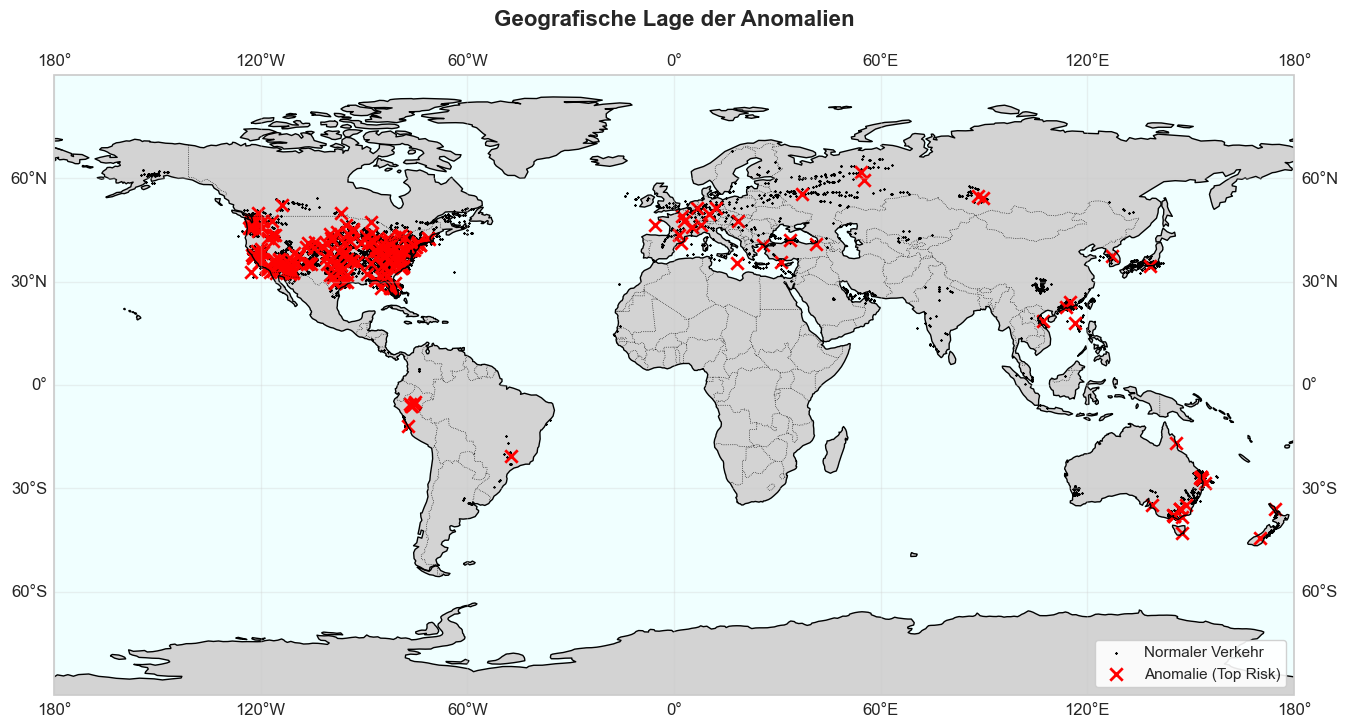

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

# SCHALLDÄMPFER: Wir unterdrücken Warnungen für den Output
warnings.filterwarnings('ignore')

print("--- DEEP DIVE: KONTEXT & LOCATION ---")

# 1. KOORDINATEN & DATEN
cols_geo = ['lat', 'lon']
for col in cols_geo:
    df_ml[col] = pd.to_numeric(df_ml[col], errors='coerce')

# WICHTIG: Wir erstellen eine explizite Kopie, damit Pandas nicht meckert
anomalies = anomalies.copy() 
for col in cols_geo:
    anomalies[col] = pd.to_numeric(anomalies[col], errors='coerce')

# 2. BEREINIGUNG (Deduplizierung)
unique_anomalies = anomalies.sort_values('velocity', ascending=False).drop_duplicates(subset=['icao24'])

# 3. WO SIND DIE? (Die Karte)
plt.figure(figsize=(16, 10))

# Geo-Projektion
ax = plt.axes(projection=ccrs.PlateCarree())

# Features
ax.add_feature(cfeature.LAND, facecolor='lightgray') 
ax.add_feature(cfeature.OCEAN, facecolor='azure')     
ax.add_feature(cfeature.COASTLINE, linewidth=1)       
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5) 

# Sample für Hintergrund
df_normal_sample = df_ml[df_ml['status'] == 'Normal'].dropna(subset=['lat', 'lon']).sample(frac=0.01, random_state=42)

print(f"✈️ Plotten von {len(df_normal_sample)} Flügen + Anomalien...")

# Normaler Verkehr
ax.scatter(df_normal_sample['lon'], df_normal_sample['lat'],
           c='black', s=1, marker='x', transform=ccrs.PlateCarree(), label='Normaler Verkehr')

# Anomalien
ax.scatter(unique_anomalies['lon'], unique_anomalies['lat'],
           c='red', s=80, marker='x', linewidth=2, transform=ccrs.PlateCarree(), label='Anomalie (Top Risk)')

# Design
ax.set_global()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
plt.title("Geografische Lage der Anomalien", fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.9)

plt.show()

### Interpretation der Weltkarte

Die Visualisierung liefert spannende Erkenntnisse über die Natur unserer Daten und der gefundenen Anomalien:

1.  **Daten-Bias & Abdeckung (Graue Punkte):**
    * Die grauen Punkte zeigen den normalen Flugverkehr. Man erkennt sofort: Unsere Datenbasis (OpenSky Network) hat die beste Abdeckung in **Nordamerika, Europa und Australien**. In Afrika und über den Ozeanen gibt es kaum Empfänger.
    * *Wichtig:* Dass wir dort keine Anomalien finden, heißt nicht, dass es keine gibt – wir haben dort nur keine Sensoren ("Selection Bias").

2.  **Cluster USA & Europa (Rote Kreuze):**
    * Wir sehen eine massive Häufung von Anomalien in den **USA** und **Mitteleuropa**.
    * *Grund:* Dies sind die Lufträume mit der höchsten Verkehrsdichte weltweit. Wo mehr geflogen wird, passieren statistisch auch mehr ungewöhnliche Manöver (oder Messfehler). Zudem gibt es in den USA sehr viel "General Aviation" (Privatpiloten, kleine Cessnas), die oft unruhiger fliegen als große Linienjets.

3.  **Plausibilitäts-Prüfung:**
    * Die Anomalien liegen fast ausschließlich über **Landmassen**.
    * Das ist ein gutes Zeichen! Es deutet darauf hin, dass es sich um **echte Flugzeuge** handelt und nicht um GPS-Artefakte im Ozean (wie der berühmte "Null-Island" Fehler bei Koordinate 0,0).

--- DATA QUALITY CHECK: DEEP DIVE ---
Total Unique Aircraft im Feed: 3,340
Davon in DB gefunden (Match):  3,331 (99.7%)


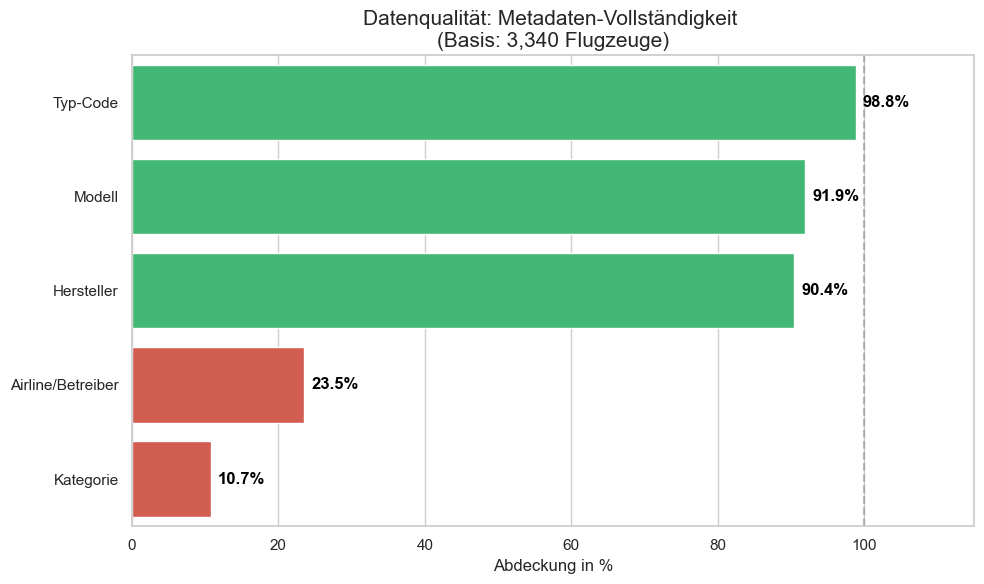


--- FAZIT ZUR DATENQUALITÄT ---
• Typ-Code: 98.8% vorhanden (Fehlt bei 1.2%)
• Modell: 91.9% vorhanden (Fehlt bei 8.1%)
• Hersteller: 90.4% vorhanden (Fehlt bei 9.6%)
• Airline/Betreiber: 23.5% vorhanden (Fehlt bei 76.5%)
• Kategorie: 10.7% vorhanden (Fehlt bei 89.3%)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

# Unterdrückt die lästigen Warnungen für sauberen Output
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

print("--- DATA QUALITY CHECK: DEEP DIVE ---")

# 1. SETUP
unique_flights_ids = df_ml['icao24'].unique()
total_flights = len(unique_flights_ids)

# Filterung der DB
df_quality = df_aircraft[df_aircraft['icao24'].isin(unique_flights_ids)].copy()

matches_count = len(df_quality)
match_rate = (matches_count / total_flights) * 100

print(f"Total Unique Aircraft im Feed: {total_flights:,}")
print(f"Davon in DB gefunden (Match):  {matches_count:,} ({match_rate:.1f}%)")

# 2. QUALITÄTS-ANALYSE
attributes = {
    'manufacturerName': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ-Code',
    'categoryDescription': 'Kategorie',
    'operator': 'Airline/Betreiber'
}

quality_stats = []

for col, label in attributes.items():
    if col in df_quality.columns:
        valid_count = df_quality[col].replace(r'^\s*$', np.nan, regex=True).notna().sum()
        pct = (valid_count / total_flights) * 100 
        quality_stats.append({'Attribute': label, 'Valid_Count': valid_count, 'Percentage': pct})

df_stats = pd.DataFrame(quality_stats).sort_values('Percentage', ascending=False)

# 3. VISUALISIERUNG
plt.figure(figsize=(10, 6))

colors = ['#2ecc71' if x > 90 else '#f1c40f' if x > 70 else '#e74c3c' for x in df_stats['Percentage']]

# FIX: hue und legend=False hinzugefügt
ax = sns.barplot(
    data=df_stats, 
    x='Percentage', 
    y='Attribute', 
    hue='Attribute',  # <--- Hier war der Fehler
    palette=colors,
    legend=False      # <--- Verhindert doppelte Legende
)

for i, v in enumerate(df_stats['Percentage']):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center', fontweight='bold')

plt.title(f"Datenqualität: Metadaten-Vollständigkeit \n(Basis: {total_flights:,} Flugzeuge)", fontsize=15)
plt.xlabel("Abdeckung in %")
plt.ylabel("")
plt.xlim(0, 115) 
plt.axvline(x=100, color='grey', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 4. TEXT-FAZIT
print("\n--- FAZIT ZUR DATENQUALITÄT ---")
for index, row in df_stats.iterrows():
    missing_pct = 100 - row['Percentage']
    print(f"• {row['Attribute']}: {row['Percentage']:.1f}% vorhanden (Fehlt bei {missing_pct:.1f}%)")

In [27]:
import pandas as pd
import glob
import os
import numpy as np

# 1. DATEN VORBEREITUNG (Lädt Daten nur, falls nicht vorhanden)
if 'df_enriched' not in locals():
    base_path = "../data/processed/run_*"
    if not glob.glob(base_path): base_path = "../../data/processed/run_*"
    latest_run = max(glob.glob(base_path), key=os.path.getctime)
    df = pd.read_parquet(latest_run)
    
    db_path = "../data/external/aircraft_database.parquet"
    if not os.path.exists(db_path): db_path = "../../data/external/aircraft_database.parquet"
    df_aircraft = pd.read_parquet(db_path)
    
    # Cleaning & Join
    df['velocity_kmh'] = pd.to_numeric(df['velocity'], errors='coerce') * 3.6
    df['baroaltitude'] = pd.to_numeric(df['baroaltitude'], errors='coerce')
    df_clean = df[df['onground'] == 'False'].dropna(subset=['velocity_kmh', 'baroaltitude'])
    df_enriched = pd.merge(df_clean, df_aircraft, on='icao24', how='left')

# 2. SZENARIEN & FILTER
scenarios = {
    "Hoch / Langsam": 
        (df_enriched['baroaltitude'] > 15000) & (df_enriched['velocity_kmh'] < 150),
    
    "Tief / Schnell": 
        (df_enriched['baroaltitude'] < 2000) & (df_enriched['velocity_kmh'] > 600),
        
    "Extreme Höhe": 
        (df_enriched['baroaltitude'] > 25000)
}

# 3. TABELLE ERSTELLEN
results = []

for label, mask in scenarios.items():
    subset = df_enriched[mask].copy()
    
    # TRICK: Wir sortieren so, dass Zeilen MIT Hersteller/Modell oben stehen!
    subset['has_info'] = subset['manufacturerName'].notna() & subset['model'].notna()
    
    # Sortieren: Erst 'has_info', dann Geschwindigkeit
    subset = subset.sort_values(by=['has_info', 'velocity_kmh'], ascending=[False, False])
    
    # Duplikate entfernen
    subset = subset.drop_duplicates(subset=['icao24'])
    
    # Top 10 Beispiele wählen
    examples = subset.head(10).copy() 
    
    if not examples.empty:
        examples['Szenario'] = label
        results.append(examples)

if results:
    final_table = pd.concat(results)
    
    # 1. Mapping definieren (Hier fügen wir typecode hinzu)
    column_mapping = {
        'Szenario': 'Szenario',
        'typecode': 'Typ-Code',          # <--- NEU HINZUGEFÜGT
        'manufacturerName': 'Hersteller',
        'model': 'Model',
        'categoryDescription': 'Beschreibung',
        'velocity_kmh': 'Geschwindigkeit in km/h',
        'baroaltitude': 'Höhe',
        'icao24': 'ICAO ID'
    }
    
    # 2. Gewünschte Reihenfolge festlegen (Szenario & Typ ganz links)
    desired_order = [
        'Szenario', 
        'Typ-Code', 
        'Hersteller', 
        'Model', 
        'Beschreibung', 
        'Geschwindigkeit in km/h', 
        'Höhe', 
        'ICAO ID'
    ]
    
    # 3. Umbenennen und Sortieren
    # Wir nehmen nur die Spalten, die im Mapping stehen
    final_view = final_table[list(column_mapping.keys())].rename(columns=column_mapping)
    
    # Jetzt die Reihenfolge erzwingen
    final_view = final_view[desired_order]
    
    # Formatierung
    final_view['Geschwindigkeit in km/h'] = final_view['Geschwindigkeit in km/h'].round(1)
    final_view['Höhe'] = final_view['Höhe'].round(0)
    final_view = final_view.fillna('-')

    print("\n--- ERGEBNIS-TABELLE (Top 10 Anomalien pro Szenario) ---")
    display(final_view)
else:
    print("Keine Anomalien in den definierten Szenarien gefunden.")


--- ERGEBNIS-TABELLE (Top 10 Anomalien pro Szenario) ---


,Szenario,Typ-Code,Hersteller,Model,Beschreibung,Geschwindigkeit in km/h,Höhe,ICAO ID
116194,Hoch / Langsam,C172,Textron Aviation Inc.,172S,-,133.1,20879.0,7c3381
170674,Hoch / Langsam,P28A,Piper,PA-28-161,-,127.2,25878.0,a46665
315584,Hoch / Langsam,P28A,Piper Aircraft Inc,PA-28-181,-,117.1,15088.0,a54d6a
468214,Hoch / Langsam,P28R,Piper,PA-28R-200,-,110.8,20330.0,a1af86
326658,Hoch / Langsam,P28A,Piper,PA-28-181,-,44.8,19599.0,ab0fd6
475393,Hoch / Langsam,FOX,-,-,-,129.6,27493.0,ad8233
561162,Hoch / Langsam,-,-,-,-,53.0,18593.0,a17bba
509659,Hoch / Langsam,-,-,-,Lighter-than-air,46.3,18014.0,a19e24
437186,Hoch / Langsam,BALL,-,-,-,41.1,16977.0,a2237d
467446,Hoch / Langsam,-,-,-,Lighter-than-air,30.5,19629.0,a26f79


### Auswertung der Anomalieanalyse

Die forensische Analyse der Top-10-Ausreißer offenbart ein differenziertes Bild und deckt neben Sensorfehlern auch eine spannende Misch-Kategorie auf.

#### 1. Szenario: Hoch / Langsam
* **Beobachtung:** Wir sehen Objekte in **18.000m bis 25.000m** Höhe, die extrem langsam sind (< 130 km/h).
* **Die Überraschung:** Diese Gruppe besteht aus zwei völlig unterschiedlichen Phänomenen:
    1.  ✅ **Valid (Ballons):** Einträge klassifiziert als `Lighter-than-air` (ohne Hersteller) auf ca. 18.000m. Das sind reale Wetterballons.
    2.  ❌ **Invalid (Klein-Flugzeuge):** Wir sehen Modelle wie **Cessna 172S** oder **Piper PA-28** auf über 20.000m Höhe.
* **Bewertung:** Die Dienstgipfelhöhe einer Cessna 172 liegt bei ca. 4.000m. Ein Flug in der Stratosphäre ist unmöglich. Hier liegen massive **Höhenmesser-Fehler** vor.

#### 2. Szenario: Tief / Schnell
* **Beobachtung:** Schwere Verkehrsflugzeuge (**Boeing 777-300ER, Airbus A321, A330**) werden in Bodennähe (< 1.500m) mit Reisegeschwindigkeit (850-970 km/h) gemessen.
* **Extremfall:** Eine **Boeing 737-800** wird mit **-274 Metern** Höhe bei fast 900 km/h geloggt. Auch eine **Boeing 777F** (Frachter) wird auf **-213 Metern** gemessen.
* **Bewertung:** ❌ **Kritischer Datenfehler.**
    * Die negativen Höhen beweisen, dass die barometrische Kalibrierung (QNH) völlig falsch ist oder der Sensor defekt ist.
    * Geschwindigkeiten von fast 1.000 km/h in 1.400m Höhe sind strukturell für das Flugwerk gefährlich (VMO Limit) und im Luftraum operativ ausgeschlossen.

#### 3. Szenario: Extreme Höhe
* **Beobachtung:** Fracht- und Langstreckenjets (**MD-11F, Boeing 777F, Airbus A300**) werden auf Höhen zwischen **33.000m und 38.000m** (ca. 110.000 - 125.000 ft) geortet.
* **Physik-Check:** Selbst moderne Business Jets (wie die gelistete Bombardier Global) fliegen maximal auf 15.500m (51.000 ft). Höhen von über 30km sind Raketen und speziellen Spionageballons vorbehalten.
* **Bewertung:** ❌ **Transponder-Encoding-Fehler.**
    * Da die Flugzeugtypen (MD-11, B777) korrekt erkannt wurden, handelt es sich eindeutig um Fehler in der Übermittlung der Höhendaten (Mode-S Altitude Encoding Glitches).